<a href="https://colab.research.google.com/github/hanhungchen/MachineLearning/blob/main/DigitClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 透過 TensorFlow 庫實作深度學習達成數字分類，資料集源自MNIST。採用MLFlow 記錄與管理學習的生命週期。

實作方法參考至：MIT 6.S191: Convolutional Neural Networks

Step 1. 匯入套件

In [ ]:
!pip install mlflow==2.6.0 --quiet

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import functools
import mlflow
from tqdm import tqdm

In [ ]:
print(mlflow.__version__)

In [ ]:
mlflow.tensorflow.autolog()

Step 2.載入 MNIST 資料集同時進行正規化

In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = (np.expand_dims(train_images, axis=-1)/255.).astype(np.float32)
train_labels = (train_labels).astype(np.int64)
test_images = (np.expand_dims(test_images, axis=-1)/255.).astype(np.float32)
test_labels = (test_labels).astype(np.int64)

11490434/11490434 [==============================] - 0s 0us/step


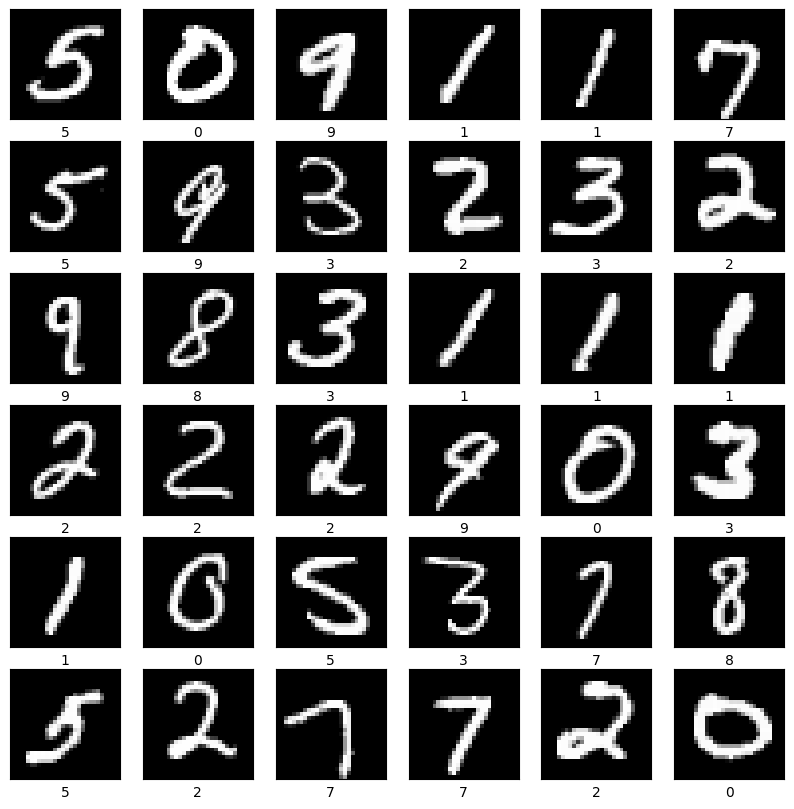

In [ ]:
# 驗證 Labels 與圖形映射關係
plt.figure(figsize=(10, 10))
random_inds = np.random.choice(6000, 36)
for i in range(36):
  plt.subplot(6, 6, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  image_ind = random_inds[i]
  plt.imshow(np.squeeze(train_images[image_ind]), cmap=plt.cm.gray)
  plt.xlabel(train_labels[image_ind])

Step 4.定義 Convolutional Neural Network

In [ ]:
Conv2D = functools.partial(tf.keras.layers.Conv2D, activation = 'relu', padding = 'same')
MaxPool2D = functools.partial(tf.keras.layers.MaxPool2D, padding = 'same')
Dense = functools.partial(tf.keras.layers.Dense)

def build_cnn_model():
  cnn_model = tf.keras.Sequential([
      # 定義輸入 Convolution layer 有 24 個權重集大小為 3 × 3 ，步伐為 1。
      Conv2D(filters = 24, kernel_size = 3, strides = 1, input_shape=(28, 28, 1)),
      MaxPool2D(pool_size = 2, strides = 2),

      Conv2D(filters = 36, kernel_size = 3, strides = 1),
      MaxPool2D(pool_size = 2, strides = 2),

      tf.keras.layers.Flatten(),

      Dense(units = 900, activation = 'relu'),
      Dense(units = 128, activation = 'relu'),
      # 輸出分類概率，Activation 採用 softmax
      Dense(units = 10, activation = 'softmax')
  ])

  return cnn_model

In [ ]:
# 檢視模型架構
cnn_model = build_cnn_model()
cnn_model.build()
print(cnn_model.summary())
# model_arc = " Conv2D(28, 28, 24)\n MaxPooling2D(14, 14, 2)\n Conv2D(14, 14, 36)\n MaxPooling2D(7, 7, 36)\n Flatten(1764)\n Dense(900)\n Dense(128)\n Dense(10)"
# mlflow.log_artifacts(model_arc)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 24)        240       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 24)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 36)        7812      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 7, 7, 36)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 1764)              0         
                                                                 
 dense_9 (Dense)             (None, 900)              

Step 5.訓練 CNN 模型

In [ ]:
def compute_accuracy(model):
  (images, labels) = (train_images[:1000], train_labels[:1000])
  images = tf.convert_to_tensor(images, dtype=tf.float32)
  preds = model.predict(images)

  acc = tf.reduce_mean(tf.cast(tf.equal(labels, np.argmax(preds, axis=1)), tf.float32))

  return acc

In [ ]:
cnn_model = build_cnn_model()

num_epochs = 2
batch_size = 16
loss_history = np.array([])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # 清除已存在進度條

mlflow.log_param('epochs', num_epochs)

for epoch in range(num_epochs):
  print(f'Epoch {epoch + 1}/{num_epochs}')

  for idx in tqdm(range(train_images.shape[0] // batch_size)):
    (images, labels) = (train_images[idx:idx + batch_size], train_labels[idx:idx + batch_size])
    images = tf.convert_to_tensor(images, dtype=tf.float32)

    # 記錄微分運算
    with tf.GradientTape() as tape:
      logits = cnn_model(images)
      loss_value = tf.keras.backend.sparse_categorical_crossentropy(labels, logits, from_logits = True)

    loss_history = np.append(loss_history, loss_value.numpy().mean())

    # Backpropagation
    grads = tape.gradient(loss_value, cnn_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, cnn_model.trainable_variables))

  acc = compute_accuracy(cnn_model)
  print(f'loss: {loss_history.mean(): .4f} - accuracy: {acc: .4f}')
  mlflow.log_metric('accuracy', acc, step=epoch)

Epoch 1/2


  0%|          | 0/3750 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
100%|██████████| 3750/3750 [04:31<00:00, 13.79it/s]


32/32 [==============================] - 1s 15ms/step
loss:  0.0562 - accuracy:  0.9280
Epoch 2/2


100%|██████████| 3750/3750 [04:50<00:00, 12.89it/s]

 1/32 [..............................] - ETA: 1s

32/32 [==============================] - 1s 15ms/step
loss:  0.0331 - accuracy:  0.9720


Step 6.測試資料

In [ ]:
predictions = cnn_model(test_images)

隨機取 20 筆測試資料觀察模型分類結果

In [ ]:
num_rows = 5
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, num_cols, i + 1)
  pick_idx = np.random.randint(low=0, high=1000)
  predict_idx = np.argmax(predictions[pick_idx])
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(f'{predict_idx} {predictions[pick_idx][predict_idx] * 100:.1f}% ({test_labels[pick_idx]})', color='blue')
  plt.imshow(test_images[pick_idx,:,:,0], cmap=plt.cm.gray)

啟動 Mlflow UI

In [ ]:
get_ipython().system_raw("mlflow ui --port 5000")

In [ ]:
!pip install pyngrok --quiet

from pyngrok import ngrok
from getpass import getpass

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
# NGROK_AUTH_TOKEN = getpass('Enter the ngrok authtoken: ')
# ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://ee13-35-230-103-198.ngrok.io
